## LDA Gensim with pyLDAvis
### by Javid Huseynov<br>March 14, 2019

In [1]:
# Uncomment the lines below to install the packages as required
#!pip install iexfinance
#!pip install pandas
#!pip install matplotlib
#!pip install gensim
!pip install pyLDAvis
#import nltk
#nltk.download()

#### Library imports and utility text cleanup function

In [4]:
import requests, json, re
import pandas as pd
import matplotlib
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from datetime import datetime
from iexfinance.stocks import get_historical_data

stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation) 

def text_cleanup(input_text):
    one = " ".join([i for i in input_text.lower().split() if i not in stopwords])
    two = "".join(re.sub(r'[^a-zA-Z ]', '', i) for i in one if i not in punctuation)
    three = [WordNetLemmatizer().lemmatize(i) for i in two.split()]
    return three

### Choose a company to get the appropriate dataset & settings

In [5]:
## Get your Webhose feeds here

There are 644 feeds for Boeing between 2018-11-01 00:00:00 and 2018-11-30 00:00:00


### Load feeds into dataframe and print

In [6]:
df_feeds = pd.DataFrame(feeds[1:],columns=feeds[0])
df_feeds

,title,date,sentiment
0,Here's The Price I'll Start Buying Boeing - Th...,2018-11-29,-0.443205
1,US pilots want more training on new Boeing jet...,2018-11-29,-0.429537
2,IMPORTANT INVESTOR NOTICE: The Schall Law Firm...,2018-11-29,-0.530027
3,US pilots want more training on Boeing 737 MAX...,2018-11-29,-0.499726
4,Here's Why Boeing (BA) Stock Looks Like a Buy ...,2018-11-29,0.382325
5,Boeing may update software after crash,2018-11-29,-0.410717
6,Air India Boeing 787 Dreamliner Vt Anh Landing...,2018-11-29,0.738266
7,Boeing CEO addresses flight system update afte...,2018-11-29,-0.543983
8,Boeing given time till 2020 to show offsets wo...,2018-11-29,0.378034
9,Prepar3D v4 | Turkish Airlines Boeing 737-800 ...,2018-11-29,0.378034


### Distribution of company mentions and sentiment by date

In [7]:
df_daily_count = df_feeds.groupby('date')['title'].count()
df_daily_count.plot(kind='bar', x='date')

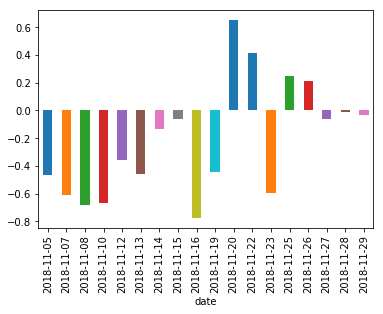

In [8]:
df_average_sentiment = df_feeds.groupby('date')['sentiment'].mean()
df_average_sentiment.plot(kind='bar', x='date')

### Train LDA topic model and display topic distribution

In [11]:
from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim
import os

titles = df_feeds[['title']].applymap(text_cleanup)['title']
dictionary = Dictionary(titles)
dictionary.filter_extremes(no_below=10, no_above=0.8)
corpora = [dictionary.doc2bow(doc) for doc in titles]

# Running and Trainign LDA model on the document term matrix.
lda_model = ldamodel.LdaModel(corpora, num_topics=7, id2word = dictionary, passes=50)

In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.229395 -0.057682       1        1  21.328417
0     -0.141740 -0.239946       2        1  16.286829
2     -0.182308  0.158125       3        1  14.828266
1      0.308751  0.029689       4        1  13.285306
3     -0.009761  0.310126       5        1  12.877268
5      0.151428 -0.080916       6        1  11.761693
6      0.103026 -0.119396       7        1   9.632231, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
24    Default  103.000000             air  103.000000  30.0000  30.0000
32    Default   78.000000            lion   78.000000  29.0000  29.0000
20    Default   68.000000              ba   68.000000  28.0000  28.0000
19    Default  122.000000             max  122.000000  27.0000  27.0000
6     Default   75.000000           pilot   75.000000  26.0000  26.0000
3     Default   72.000000             jet   72.000000  25.0000  25.0000
2     Default  126.000000           crash  126.000000  24.0000  24.0000
28    Default   81.000000         airline   81.000000  23.0000  23.0000
58    Default   39.000000              co   39.000000  22.0000  22.0000
4     Default   77.000000             new   77.000000  21.0000  21.0000
52    Default   31.000000          market   31.000000  20.0000  20.0000
0     Default   43.000000         company   43.000000  19.0000  19.0000
36    Default   36.000000        aircraft   36.000000  18.0000  18.0000
8     Default   49.000000               u   49.000000  17.0000  17.0000
44    Default   34.000000             say   34.000000  16.0000  16.0000
69    Default   51.000000         boeings   51.000000  15.0000  15.0000
73    Default   40.000000        analysis   40.000000  14.0000  14.0000
34    Default   25.000000          airway   25.000000  13.0000  13.0000
47    Default   31.000000        american   31.000000  12.0000  12.0000
91    Default   28.000000         unaware   28.000000  11.0000  11.0000
90    Default   27.000000        function   27.000000  10.0000  10.0000
87    Default   26.000000            last   26.000000   9.0000   9.0000
42    Default   22.000000      indonesian   22.000000   8.0000   8.0000
33    Default   32.000000            week   32.000000   7.0000   7.0000
60    Default   23.000000           share   23.000000   6.0000   6.0000
40    Default   31.000000          airbus   31.000000   5.0000   5.0000
68    Default   22.000000          launch   22.000000   4.0000   4.0000
14    Default   23.000000        investor   23.000000   3.0000   3.0000
29    Default   19.000000         turkish   19.000000   2.0000   2.0000
82    Default   24.000000         control   24.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
83     Topic7   11.829139         british   12.659291   2.2722  -3.0874
55     Topic7   10.855049             kim   11.685118   2.2664  -3.1734
64     Topic7    9.880892      additional   10.710958   2.2594  -3.2674
67     Topic7   11.726613             win   14.630831   2.1188  -3.0961
59     Topic7    9.882264         private   13.579980   2.0222  -3.2672
21     Topic7   14.531915           stock   23.528576   1.8582  -2.8816
35     Topic7    9.713303           first   24.294914   1.4233  -3.2845
39     Topic7    6.286736        delivers   18.459423   1.2629  -3.7195
49     Topic7    3.711775         service   11.656845   1.1957  -4.2465
26     Topic7    6.002681          flight   22.547462   1.0166  -3.7658
25     Topic7    2.528445           india   10.342968   0.9314  -4.6304
3      Topic7   16.177738             jet   72.200073   0.8443  -2.7743
28     Topic7   16.971014         airline   81.441063   0.7717  -2.7265
71     Topic7    2.146399            sell   10.569418   0.7459  -4.7942
37     Topic7    3.571367  marketscreener   23.677044   0.4485  -4.2850
30     Topic7  